In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from data import read_preprocessed_data
from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import PCA
import seaborn as sns

color_palette = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]

#Użżywamy sklearn Robust Scaler
data_scaled = read_preprocessed_data(std=False, robust=True)

c:\Users\Noka9\Desktop\customer-profile-analysis\data/marketing_campaign.csv


In [2]:
#model mieszanin gaussa

gmm = GaussianMixture(
    # Stosujemy model mieszanin gaussa dla wybranej liczby klastrów
    n_components=3,          
    covariance_type='tied',  
    # Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
    random_state=42
)
data_scaled['Cluster'] = gmm.fit_predict(data_scaled)

Text(0.5, 1.0, 'Metoda GMM dla trzech klastrów z wizualizacją PCA ')

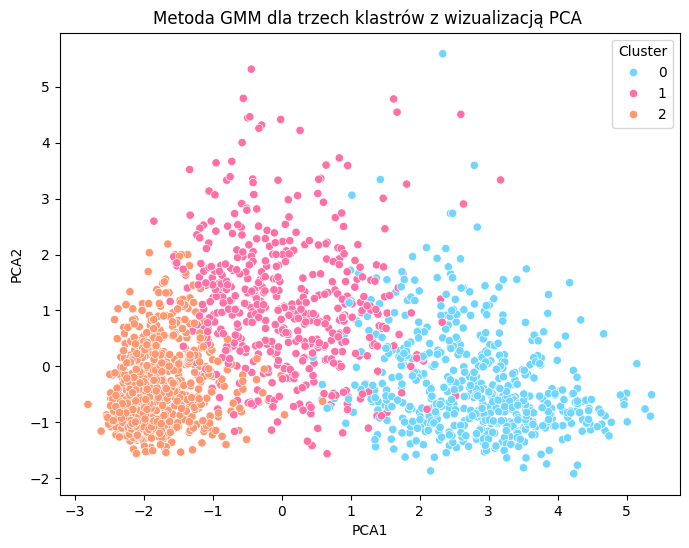

In [3]:
# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
color_palette = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_palette[:-1]
)
plt.title("Metoda GMM dla trzech klastrów z wizualizacją PCA ")

In [4]:
#wariancja wyjaśniona przez PCA1 oraz PCA2
print("PCA1: ", round(pca.explained_variance_ratio_[0], 2))
print("PCA2: ", round(pca.explained_variance_ratio_[1], 2))
#część całkowitej wariancji danych jaką udało się przedstawić na wykresie
print("Suma wyjaśnionej wariancji: ", round(pca.explained_variance_ratio_.sum(), 2))

PCA1:  0.43
PCA2:  0.12
Suma wyjaśnionej wariancji:  0.55


In [5]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster


#Dla łatwiejszej analizy wydatków zliczamy procent przychodów jaki stanowią wydatki (pozwala identyfikować rozrzutnych klientów)
original_data["Spending_To_Income_Ratio"] = original_data["Spent"]/original_data["Income"]
cluster_summary["Spending_To_Income_Ratio_Mode"] = original_data.groupby("Cluster")["Spending_To_Income_Ratio"].agg(lambda x: x.mode()[0])

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()
# Podsumowanie klastrów

kl1 = cluster_summary.iloc[1].values.tolist()
cluster_summary.transpose()

c:\Users\Noka9\Desktop\customer-profile-analysis\data/marketing_campaign.csv


Cluster,0,1,2
Income,73037.033333,56886.76306,33746.34465
Kidhome,0.074603,0.248134,0.811728
Teenhome,0.307937,0.869403,0.446502
Recency,49.444444,48.621269,48.98251
MntWines,545.492063,437.815299,37.675926
MntFruits,52.865873,14.675373,4.631687
MntMeatProducts,368.710714,108.072761,21.445473
MntFishProducts,81.798413,19.777985,6.340535
MntSweetProducts,53.8,14.94403,4.574074
MntGoldProds,65.884921,52.263993,14.611626


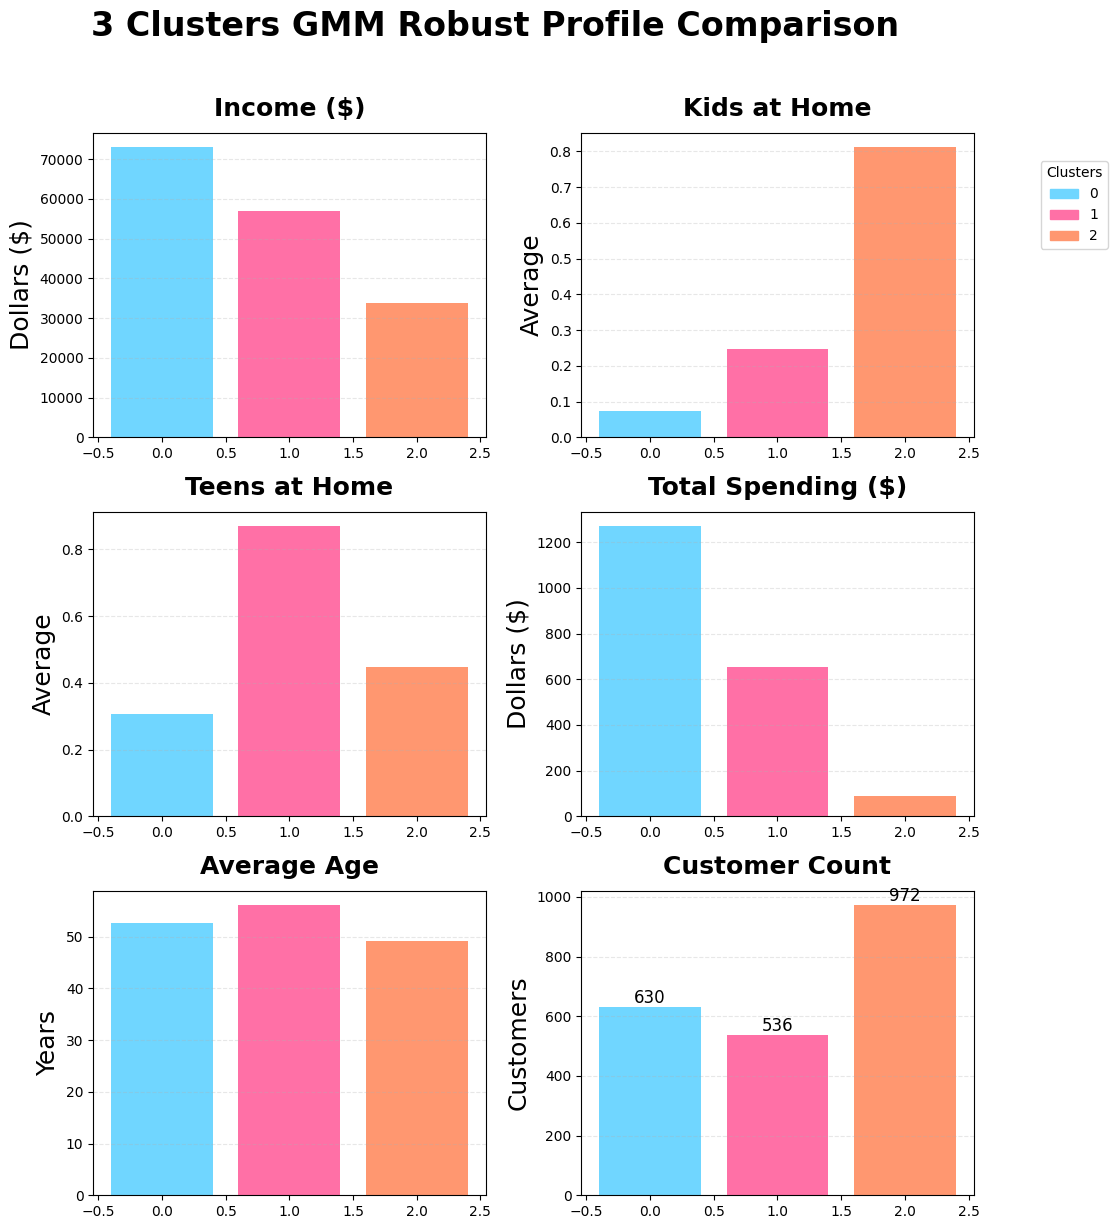

In [6]:
# Data preparation
variables = ['Income', 'Kidhome', 'Teenhome', 'Spent', 'Age', 'Count']
titles = ['Income ($)', 'Kids at Home', 'Teens at Home', 'Total Spending ($)', 'Average Age', 'Customer Count']
cluster_labels = cluster_summary.index

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle('3 Clusters GMM Robust Profile Comparison', fontsize=24, y=1.02, weight='bold')

# Plot each variable
for ax, var, title in zip(axes.flatten(), variables, titles):
    values = cluster_summary[var]
    
    bars = ax.bar(cluster_labels, values, color=color_palette)
    ax.set_title(title, pad=12, weight='bold', fontsize=18)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add value labels for Count
    if var == 'Count':
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=12)
    
    # Format y-axis for monetary values
    if var in ['Income', 'Spent']:
        ax.set_ylabel('Dollars ($)', fontsize=18)
    elif var == 'Age':
        ax.set_ylabel('Years', fontsize=18)
    elif var == 'Count':
        ax.set_ylabel('Customers', fontsize=18)
    else:
        ax.set_ylabel('Average', fontsize=18)

plt.tight_layout()

# Add legend once
handles = [plt.Rectangle((0,0),1,1, color=color) 
           for color in color_palette]
fig.legend(handles, cluster_labels, 
           title='Clusters', 
           loc='upper right', 
           bbox_to_anchor=(1.12, 0.9))

plt.show()

In [7]:
 #model mieszanin gaussa
data_scaled = read_preprocessed_data(std=False, robust=True)
gmm = GaussianMixture(
    # Stosujemy model mieszanin gaussa dla wybranej liczby klastrów
    n_components=4,          
    covariance_type='tied',  
    # Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
    random_state=42
)
data_scaled['Cluster'] = gmm.fit_predict(data_scaled)

c:\Users\Noka9\Desktop\customer-profile-analysis\data/marketing_campaign.csv


Text(0.5, 1.0, 'Metoda GMM dla czterech klastrów z wizualizacją PCA ')

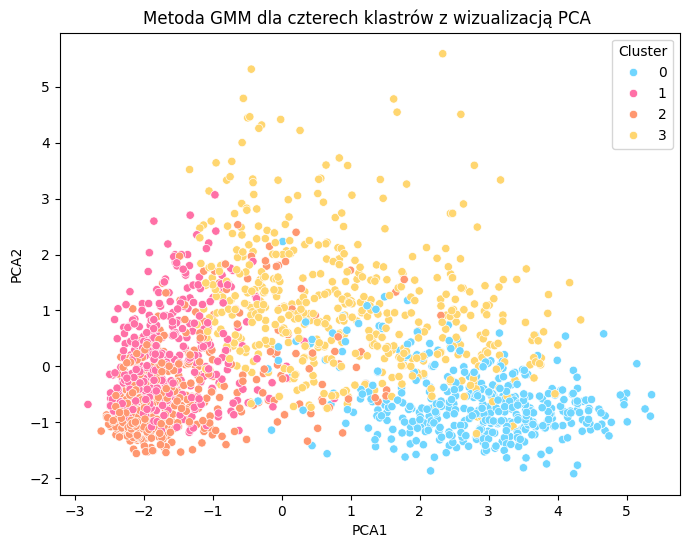

In [8]:
# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
color_palette = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_palette
)
plt.title("Metoda GMM dla czterech klastrów z wizualizacją PCA ")

In [9]:
#wariancja wyjaśniona przez PCA1 oraz PCA2
print("PCA1: ", round(pca.explained_variance_ratio_[0], 2))
print("PCA2: ", round(pca.explained_variance_ratio_[1], 2))
#część całkowitej wariancji danych jaką udało się przedstawić na wykresie
print("Suma wyjaśnionej wariancji: ", round(pca.explained_variance_ratio_.sum(), 2))

PCA1:  0.43
PCA2:  0.12
Suma wyjaśnionej wariancji:  0.55


In [10]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster


#Dla łatwiejszej analizy wydatków zliczamy procent przychodów jaki stanowią wydatki (pozwala identyfikować rozrzutnych klientów)
original_data["Spending_To_Income_Ratio"] = original_data["Spent"]/original_data["Income"]
cluster_summary["Spending_To_Income_Ratio_Mode"] = original_data.groupby("Cluster")["Spending_To_Income_Ratio"].agg(lambda x: x.mode()[0])

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()
# Podsumowanie klastrów
cluster_summary.transpose()


c:\Users\Noka9\Desktop\customer-profile-analysis\data/marketing_campaign.csv


Cluster,0,1,2,3
Income,75047.04034,41845.841683,30910.756844,61941.996344
Kidhome,0.065817,0.755511,0.795491,0.122486
Teenhome,0.0,1.03006,0.0,1.060329
Recency,49.450106,49.571142,49.006441,48.193784
MntWines,591.85138,69.028056,46.502415,498.839122
MntFruits,49.142251,3.893788,8.404187,28.090494
MntMeatProducts,394.745754,26.292585,33.914654,166.276965
MntFishProducts,77.420382,5.43487,12.717391,38.797989
MntSweetProducts,49.794055,3.91984,8.573269,28.550274
MntGoldProds,64.816348,14.713427,20.779388,60.235832


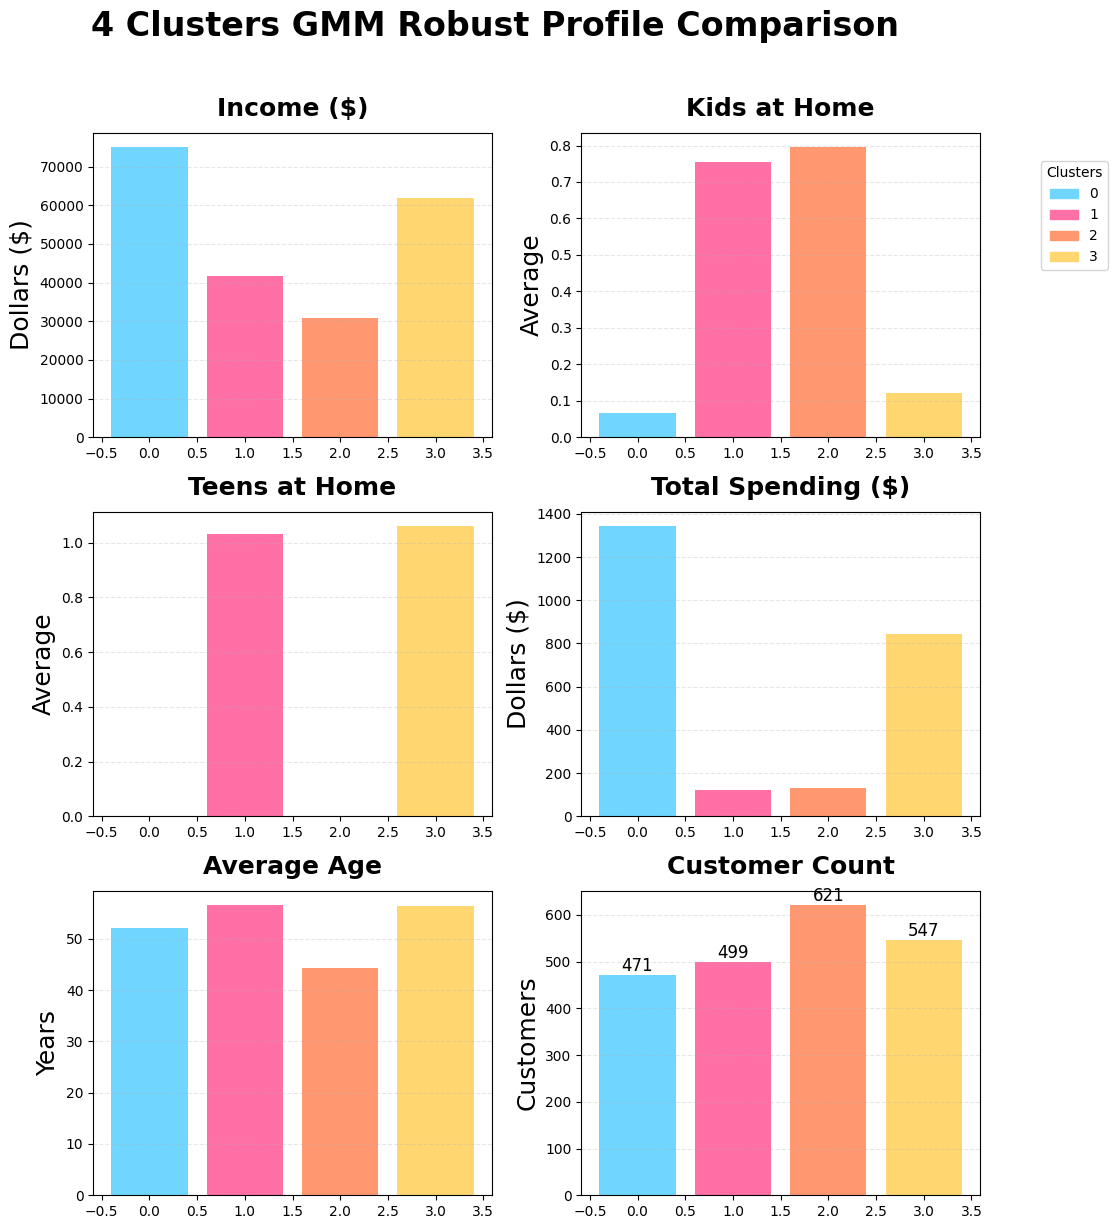

In [11]:
# Data preparation
variables = ['Income', 'Kidhome', 'Teenhome', 'Spent', 'Age', 'Count']
titles = ['Income ($)', 'Kids at Home', 'Teens at Home', 'Total Spending ($)', 'Average Age', 'Customer Count']
cluster_labels = cluster_summary.index

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle('4 Clusters GMM Robust Profile Comparison', fontsize=24, y=1.02, weight='bold')

# Plot each variable
for ax, var, title in zip(axes.flatten(), variables, titles):
    values = cluster_summary[var]
    
    bars = ax.bar(cluster_labels, values, color=color_palette)
    ax.set_title(title, pad=12, weight='bold', fontsize=18)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add value labels for Count
    if var == 'Count':
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=12)
    
    # Format y-axis for monetary values
    if var in ['Income', 'Spent']:
        ax.set_ylabel('Dollars ($)', fontsize=18)
    elif var == 'Age':
        ax.set_ylabel('Years', fontsize=18)
    elif var == 'Count':
        ax.set_ylabel('Customers', fontsize=18)
    else:
        ax.set_ylabel('Average', fontsize=18)

plt.tight_layout()

# Add legend once
handles = [plt.Rectangle((0,0),1,1, color=color) 
           for color in color_palette]
fig.legend(handles, cluster_labels, 
           title='Clusters', 
           loc='upper right', 
           bbox_to_anchor=(1.12, 0.9))

plt.show()